In [25]:
from __future__ import print_function, division

# 导入网络模块
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# 计算机视觉模块
import torchvision
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms, models, datasets

# 导入图像分析函数
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 导入基本库
import os
import time
import copy

# 打开交互模式，可以看到动态过程
plt.ion()

In [26]:
data_transfroms = {
    'train':transforms.Compose([
        # 随机裁剪图片，裁剪得到224*224大小的图片
        transforms.RandomResizedCrop(224),
        # 随机图片翻转和旋转
        transforms.RandomHorizontalFlip(),
        # 将图片转化成张量
        transforms.ToTensor(),
        # 张量正则化
        transforms.Normalize(
            mean=[0.485,0.456,0.406],
            std =[0.229,0.224,0.225],)          
    ]),
    'val':transforms.Compose([
        # 改变图片大小，得到256，256的图片
        transforms.Resize(256),
        # 图片中心裁剪，得到224，224的图片
        transforms.CenterCrop(224),
        # 图片张量化
        transforms.ToTensor(),
        # 张量正则化
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
}

In [27]:
# 定义类别名字和主路径
class_list = ['Minor','Moderate','Normal','Serious']
class_dataset = ['train','val']
data_dir = './leaf_dataset'

# 对图片进行预处理，按训练集和测试集进行分类
Image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transfroms[x]) 
                  for x in class_dataset}

# 加载数据集，每批次为4个，加载线程为4线程
dataloaders = {x:DataLoader(Image_datasets[x],
                            batch_size=2,
                            shuffle=True,
                            num_workers=4) 
               for x in class_dataset}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset_sizes = {x:len(Image_datasets[x]) for x in class_dataset}
# {'train': 64, 'val': 16}

class_names = Image_datasets['train'].classes
# ['Minor', 'Moderate', 'Normal', 'Serious']

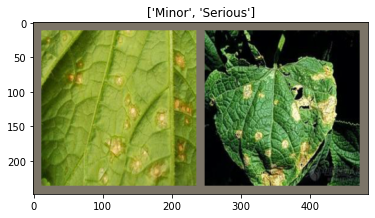

In [28]:
def imshow(inp, title=None):
    # 于 plt.imshow() 实际输入的是(imagesize,imagesize,channels),
    # 而 def imshow() 中，参数img的格式为(channels,imagesize,imagesize),
    # 这两者的格式不一致，我们需要调用一次 np.transpose 函数，即 np.transpose(npimg,(1,2,0))
    # 将 npimg 的数据格式由（channels,imagesize,imagesize）转化为（imagesize,imagesize,channels）
    # 把 0，1，2 转换成 1，2，0
    inp = inp.numpy().transpose((1,2,0))
    
    # 使用 ImageNet 训练数百万次得到 平均值 和 标准差
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    
    # x = (x-mean)/std 
    inp = std * inp + mean
    
    # np.clip(a, a_min, a_max, out)
    # a为输入数组。a_min为限定的最小值，a_max为限定的最大值，这两个都可以是数组，但是shape得跟a一样
    inp = np.clip(inp, 0, 1)
    
    # 展示图片
    plt.imshow(inp)
    
    # 如果title被定义，那么久按照定义的title显示
    if title is not None:
        plt.title(title)
    
    # 如果当前有活动的图形，在pause函数运行前，图形将会更新并显示，在等待期间事件循环会一直运行，直到暂停时间0.001秒后结束
    plt.pause(0.001)

# 迭代训练集，得到训练集的输入值和类型，类型为整数
# next(iter())这是一起用的，因为dataloader设置了每2展示
inputs, classes = next(iter(dataloaders['train']))

# 输出图像，用图像做一个‘网格图’
out = torchvision.utils.make_grid(inputs, padding=12)

# classes = {'Minor':0,'Moderate':1,'Normal':2,'Serious':3}
imshow(out, title=[class_names[x] for x in classes])

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    # time.time()返回1970纪元后的秒数浮点数
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                # 启用 Batch Normalization 和 Dropout
                # 保证BN层能够用到每一批数据的均值和方差
                model.train()
            else:
                # 不启用 Batch Normalization 和 Dropout。
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 参数梯度的手动归零
                optimizer.zero_grad()
                
                # 前向传播
                # set_grad_enabled == TRUE 时，保证接下来的tensor都是可以求导的
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # torch.max() 返回两个值，1是dim=1的简写，输出所在‘行’的最大值
                    # 第一个是value；第二个是value所在的index，也就是preds
                    # _表示具体的value，也就是最大值
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 迁移？
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.
          format(time_elapsed // 60, time_elapsed % 60))
    
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [30]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0 
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
                
        model.train(mode=was_training)

In [31]:
model_ft = models.resnet18(pretrained=True)
num_fits = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_fits, 4)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma=0.1)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# ConvNet 固定特征提取器 
# 卷积模型选择18层残差网络
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 输入的特征数
num_fits = model_conv.fc.in_features
model_conv.fc = nn.Linear(512, 2)
model_conv = model_conv.to(device)

# loss计算
criterion = nn.CrossEntropyLoss()

# 卷积优化方法随机梯度下降
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 学习率指数
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size = 7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv,
                         criterion,
                         optimizer_conv,
                         exp_lr_scheduler,
                         num_epochs=25)

Epoch 1/25
----------


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [ ]:
visualize_model(model_conv)
plt.ioff()
plt.show()